# **Feature Engineering**

## Objectives

* Determine how to normalize our features, if possible.

* Minor data preparation.

* Split cleaned data into train, test, and experimentaion (for deployed web app) sets.

* Preliminary pipeline.

## Inputs

* `'game_data_clean.csv'` created at the end of Notebook 02.

* Insight from the previous notebook.

## Outputs

* Transormations and the features they will normalize.

* Train and test sets for our models to be trained and evaluated on.

* An experimentation set consisting of the most recent season in the dataset.

* A preliminary pipeline for the next notebook to build on.

#### Change working directory

In [1]:
import os

home_dir = "/workspace/pp5-ml-dashboard"
csv_dir = "datasets/clean/csv"
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our cleaned dataset as well as some of the packages that we will be using.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import get_df, save_df

game_data = get_df("game_data_clean", csv_dir)

## Section 1: Minor adjustments
We will make some minor adjustments, like we did at the beginning of the last notebook.

In [4]:
game_data.head()

,season_id,team_id_home,team_name_home,wl_home,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,day,month,year
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,21985,1610612737,Atlanta Hawks,L,41.0,92.0,0.0,3.0,9.0,18.0,...,40.0,21.0,11.0,7.0,17.0,19.0,100.0,25,10,1985
28500006,21985,1610612758,Sacramento Kings,L,39.0,88.0,0.0,2.0,26.0,41.0,...,42.0,19.0,7.0,7.0,18.0,32.0,108.0,25,10,1985
28500010,21985,1610612765,Detroit Pistons,W,39.0,88.0,0.0,1.0,40.0,49.0,...,41.0,27.0,10.0,7.0,20.0,32.0,116.0,25,10,1985
28500011,21985,1610612762,Utah Jazz,L,42.0,82.0,0.0,2.0,24.0,38.0,...,47.0,23.0,10.0,7.0,19.0,28.0,112.0,25,10,1985
28500008,21985,1610612744,Golden State Warriors,L,36.0,91.0,0.0,4.0,33.0,52.0,...,44.0,26.0,11.0,3.0,22.0,40.0,119.0,25,10,1985


We are going to modify the dataframe before doing any feature scaling or transformations of our data. We are going to drop metadata columns like `'game_id'`, `'team_id'`, as well as `'day'`, `'month'`, and `'year'`. We will also need to change the column `'wl_home'`. We will also add column to distinguish between regular season and play off games. We will also replace `'season_id'` with `'season'`, which is essentially the year.

We will set aside the most recent records we have so that users can make predictions using our models.

In [6]:
game_pre = game_data.drop(labels=["team_id_home", "team_id_away"], axis=1)

game_pre["home_wins"] = game_pre.apply(
    lambda x: 1 if x["wl_home"] == "W" else 0, axis=1
)
game_pre.drop(labels=["wl_home"], axis=1, inplace=True)

game_pre["play_off"] = game_pre.apply(
    lambda x: 1 if str(x["season_id"])[0] == "4" else 0, axis=1
)
game_pre["season"] = game_pre.apply(
    lambda x: int((x["season_id"] % 10000) - 1985), axis=1
)
game_pre.drop(labels=["season_id"], axis=1, inplace=True)


game_pre.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44909 entries, 28500005 to 42200405
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   team_name_home   44909 non-null  object 
 1   fgm_home         44909 non-null  float64
 2   fga_home         44909 non-null  float64
 3   fg3m_home        44909 non-null  float64
 4   fg3a_home        44909 non-null  float64
 5   ftm_home         44909 non-null  float64
 6   fta_home         44909 non-null  float64
 7   oreb_home        44909 non-null  float64
 8   dreb_home        44909 non-null  float64
 9   reb_home         44909 non-null  float64
 10  ast_home         44909 non-null  float64
 11  stl_home         44909 non-null  float64
 12  blk_home         44909 non-null  float64
 13  tov_home         44909 non-null  float64
 14  pf_home          44909 non-null  float64
 15  pts_home         44909 non-null  float64
 16  plus_minus_home  44909 non-null  int64  
 17  te

We have now removed a couple columns and converted some of the categorical data to numerical data.

Due to our cut off at 1985, we do not need to impute any values. This is quite convenient.

---

## Section 2: Train/Test split
We now split the data into train and test sets. Before we do this, we will remove the most recent season for experimentation with the model later. This is so that the user can experiment with the predictor on recent games.

In [7]:
recent_year = game_pre["season"].max()
latest_season = game_pre.query(f"season == {recent_year}")
game_pre_split = game_pre.query(f"season != {recent_year}")
game_pre_split.drop(
    labels=["day", "month", "year", "team_name_home", "team_name_away"],
    axis=1,
    inplace=True,
)

for col in game_pre.columns:
    game_pre[col] = game_pre[col].astype("int32")

save_df(latest_season, "latest_season", "datasets/clean/csv")
save_df(game_pre_split, "game_pre_split", "datasets/clean/csv")

Now we can split the dataset into train and test sets.

In [9]:
from sklearn.model_selection import train_test_split
from src.utils import save_df

print(game_pre_split.shape)

X_TrainSet, X_TestSet, y_TrainSet, y_TestSet = train_test_split(
    game_pre_split.drop(labels=["home_wins"], axis=1),
    game_pre_split["home_wins"],
    test_size=0.2,
    random_state=42,
)
print(f"{X_TrainSet.shape=} \n{X_TestSet.shape=}")

train_dir = "datasets/train/classification"
save_df(X_TrainSet, "X_TrainSet", train_dir, index=False)
save_df(y_TrainSet, "y_TrainSet", train_dir, index=False)

test_dir = "datasets/test/classification"
save_df(X_TestSet, "X_TestSet", test_dir, index=False)
save_df(y_TestSet, "y_TestSet", test_dir, index=False)

(43595, 34)
X_TrainSet.shape=(34876, 33) 
X_TestSet.shape=(8719, 33)



---

## Section 3: Feature Selection
As mentioned, there is no missing data for us to deal with since we only consider games after 1985.

In the next notebook, we will validate Hypothesis 1 by dropping certain features and seeing how it impacts the performance and innate feature selection of the models. We will therefore leave them in for the time being. Specifically,  we will first drop `'plus_minus_home'`, then `'pts'` as well,a nd finally `'fgm'`,`'ftm'`, `'fg3m'`, since these allow the model to compute the winner directly. We will take an agnostic approach though so that we can tinker with our model and see how large of an impact these features actually have on the model. We do not remove the attempts though as while they correlate with the score, and even give an upper bound, they do not control it completely.

In [11]:
TRIVIAL = ["plus_minus_home", "pts_home", "pts_away"]
made_shots = ["ftm", "fgm", "fg3m"]
POINTS_REL = [feat + "_home" for feat in basic]
POINTS_REL += [feat + "_away" for feat in basic]
POINTS_REL += TRIVIAL
META = ["season", "play_off"]

We will also drop metadata like `'play_off'` and `'season'` as part of our pipeline. We will leave these features in the data sets though.

In our correlation study in the last notebook, we found that many pairs had a correlation coefficient larger than 0.7. In our initial search for a model, we will use a threshold of 0.6. This threshold, for the correlation selection step, will tell the selector to throw out features if they are more strongly correlated than 0.6. FollowingWe our selection of models to investigate further, we will treat threshold as a hyperparameter. Note that since we dropped `'play_off'` and `'season'` all of our data is numerical, so we do not need to encode any categorical data.

In [13]:
from feature_engine.selection import DropFeatures, SmartCorrelatedSelection
from sklearn.pipeline import Pipeline


THRESH = 0.6


def pipeline(to_drop=None, threshold=THRESH):
    if to_drop is None:
        to_drop = META
    else:
        to_drop.extend(META)
    pipeline = Pipeline(
        [
            ("dropper", DropFeatures(features_to_drop=to_drop)),
            (
                "corr_selector",
                SmartCorrelatedSelection(
                    method="pearson",
                    threshold=threshold,
                    selection_method="variance",
                ),
            ),
        ]
    )
    return pipeline

Let's see which features are selected in the `'corr_selector'` step.


In [25]:
base_pipe = pipeline()
X_transformed = base_pipe.fit_transform(X_TrainSet)

print(base_pipe["corr_selector"].correlated_feature_sets_)
print(base_pipe["corr_selector"].features_to_drop_)

[{'ast_home', 'pts_home', 'fgm_home'}, {'fg3a_home', 'fg3a_away', 'fg3m_home'}, {'fta_home', 'pf_away', 'ftm_home'}, {'dreb_home', 'reb_home'}, {'tov_away', 'stl_home'}, {'stl_away', 'tov_home'}, {'fta_away', 'ftm_away', 'pf_home'}, {'ast_away', 'pts_away', 'fgm_away'}, {'reb_away', 'dreb_away'}]
['fgm_home', 'fg3m_home', 'ftm_home', 'dreb_home', 'ast_home', 'stl_home', 'pf_home', 'fgm_away', 'fg3a_away', 'ftm_away', 'dreb_away', 'ast_away', 'stl_away', 'pf_away']


It is quite interesting that it dropped successful shots as opposed to attempted shots. It will be interesting to see how the models perform.

---

## Section 4: Feature Transformation

We will transform the features to see if we can get their distributions to be closer to a normal distribution. We loosely follow the ideas in Section 9 of the Feature Engine lessons. Note that the documentation for Pingouin suggests that `'normaltest'` and `'jarque_bera'` are better methods for larger datasets. 

We had to modify the versions of certain packages. Jarque-Bera is no longer available in `pingouin`, so we will use the version from `scipy`.


In [15]:
from feature_engine import transformation as vt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pingouin as pg
from scipy.stats import jarque_bera as jb


TRANSFORMERS = {
    "log_e": (vt.LogTransformer, False),
    "log_10": (vt.LogTransformer, "10"),
    "reciprocal": (vt.ReciprocalTransformer, False),
    "power": (vt.PowerTransformer, False),
    "box_cox": (vt.BoxCoxTransformer, False),
    "yeo_johnson": (vt.YeoJohnsonTransformer, False),
}


# Inspired by code from the Churnometer walkthrough project
def transformer_evaluation(df, col):
    col_trans = pd.DataFrame()
    col_trans[col] = df[col]
    for transform in TRANSFORMERS:
        new_col = col + "-" + transform
        col_trans[new_col] = df[col]
        param = TRANSFORMERS[transform][1]
        transformer = TRANSFORMERS[transform][0]
        if param:
            t = transformer(variables=[new_col], base=param)
        else:
            t = transformer(variables=[new_col])
        try:
            col_trans = t.fit_transform(col_trans)
        except Exception as e:
            print(str(e))
            print(f"dropping transformer {transform}")
            col_trans.drop([new_col], axis=1, inplace=True)
    return col_trans


def compute_jb_score(df):
    scores = {}
    for col in df.columns:
        scores[col] = jb(df[col].dropna())[1]
    scores_df = pd.Series(scores).to_frame(name="pval")
    scores_df["normal"] = scores_df.apply(lambda x: x["pval"] > 0.05, axis=1)
    return scores_df


def normality_scores(df, method):
    normality_scores = {}
    for col in df.columns:
        col_trans = transformer_evaluation(df, col)
        if method == "normaltest":
            score = pg.normality(col_trans, method=method)
        elif method == "jarque_bera":
            score = compute_jb_score(col_trans)
        score.sort_values("pval", ascending=False, inplace=True)
        score["pval"] = score["pval"].apply(lambda x: round(x, 4))
        normality_scores[col] = score
    return normality_scores

In [17]:
scores_jb = normality_scores(X_transformed, "jarque_bera")
scores_nt = normality_scores(X_transformed, "normaltest")
transformed_cols = {
    col: transformer_evaluation(X_transformed, col) for col in X_transformed.columns
}

Some variables contain zero or negative values, can't apply log
dropping transformer log_e
Some variables contain zero or negative values, can't apply log
dropping transformer log_10
Some variables contain the value zero, can't apply reciprocal transformation.
dropping transformer reciprocal
Data must be positive.
dropping transformer box_cox
Some variables contain zero or negative values, can't apply log
dropping transformer log_e
Some variables contain zero or negative values, can't apply log
dropping transformer log_10
Some variables contain the value zero, can't apply reciprocal transformation.
dropping transformer reciprocal
Data must be positive.
dropping transformer box_cox
Some variables contain zero or negative values, can't apply log
dropping transformer log_e
Some variables contain zero or negative values, can't apply log
dropping transformer log_10
Data must be positive.
dropping transformer box_cox
Some variables contain zero or negative values, can't apply log
dropping tr

Many of the transformations can not be applied because of the presence of zero values. This is unavoidable. Let's see if we had any luck finding a transformation that would bring the distributions more in line.

In [19]:
success_jb = {col: scores_jb[col].query("normal == True") for col in scores_jb}
success_nt = {col: scores_nt[col].query("normal == True") for col in scores_nt}


best = {}
for col in success_jb:
    if len(success_jb[col]) > 0:
        best[col] = (success_jb[col].index[0], success_jb[col].pval[0])
for col in success_nt:
    if len(success_nt[col]) > 0:
        if success_nt[col].pval[0] > success_jb[col].pval[0]:
            best[col] = (success_nt[col].index[0], success_nt[col].pval[0])
print(len(best))

8


It seems we have been successful. Let's look at the qq-plot of a sampling of the most successful transformations relative to the qq-plot of the original distribution. We are not going to be the most particular if the p-values are good.

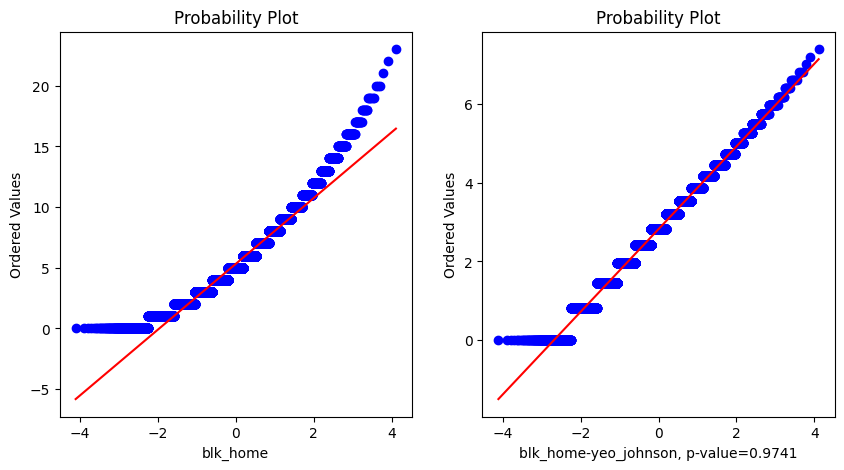

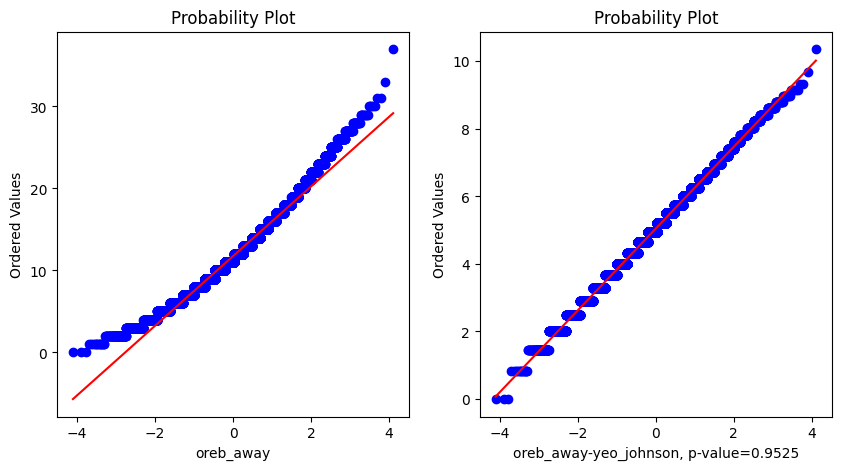

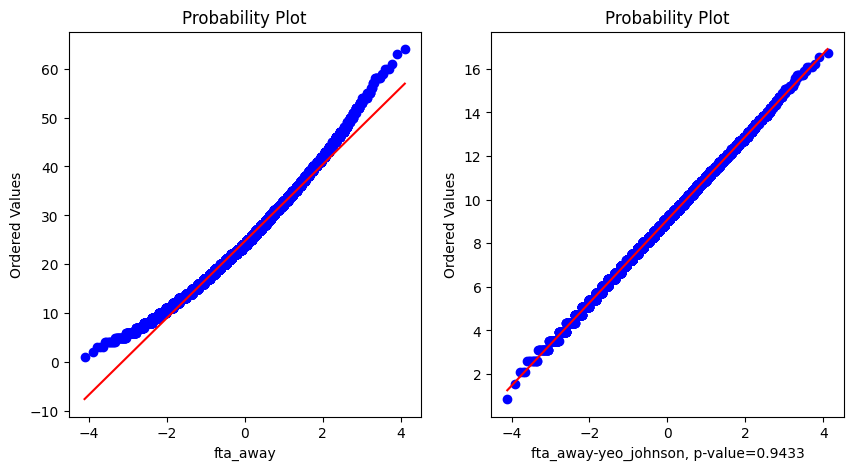

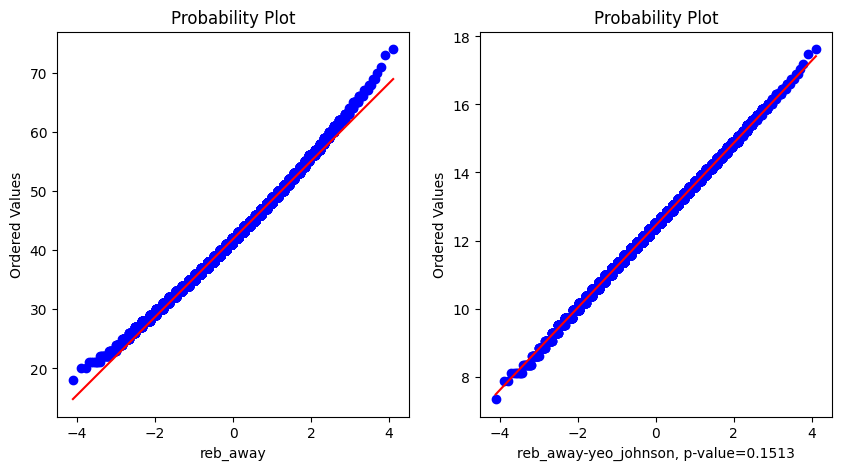

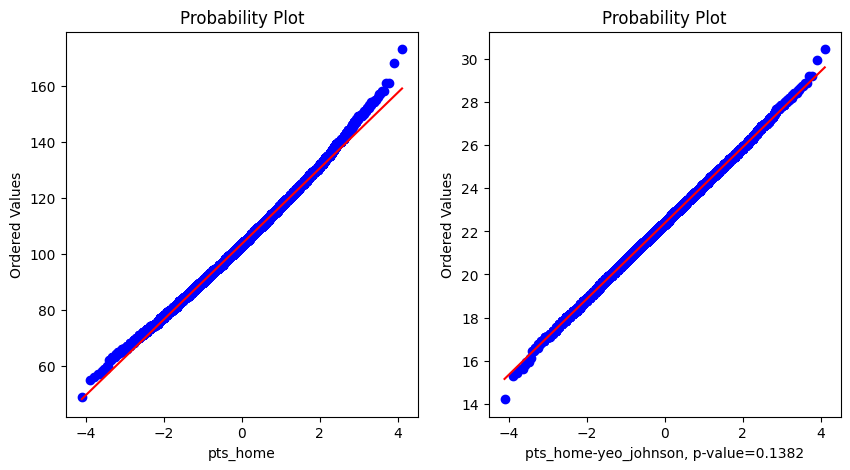

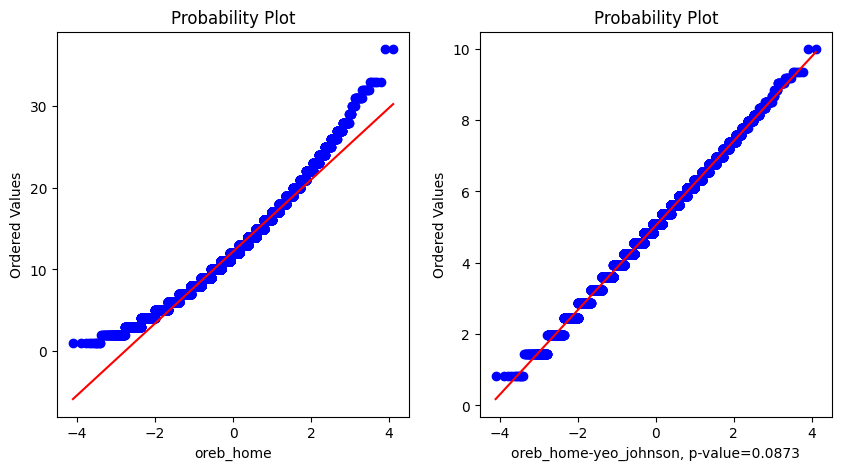

[('blk_home', 'blk_home-yeo_johnson', 0.9741), ('oreb_away', 'oreb_away-yeo_johnson', 0.9525), ('fta_away', 'fta_away-yeo_johnson', 0.9433), ('fta_home', 'fta_home-box_cox', 0.8999), ('pts_away', 'pts_away-yeo_johnson', 0.4138), ('reb_away', 'reb_away-yeo_johnson', 0.1513), ('pts_home', 'pts_home-yeo_johnson', 0.1382), ('oreb_home', 'oreb_home-yeo_johnson', 0.0873)]


In [20]:
from scipy.stats import probplot

best_sorted = [(key, value[0], value[1]) for key, value in best.items()]
best_sorted.sort(key=lambda x: x[2], reverse=True)
sample = best_sorted[:3] + best_sorted[-3:]
for item in sample:
    col, transform, pval = item
    transform_name = transform.split("-")[1]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(121)
    probplot(transformed_cols[col][col], plot=sns.mpl.pyplot)
    plt.xlabel(f"{col}")
    plt.subplot(122)
    probplot(transformed_cols[col][transform], plot=sns.mpl.pyplot)
    plt.xlabel(f"{transform}, p-value={pval}")
    plt.show()
print(best_sorted)

We now need to add these transformations to our pipeline.

In [21]:
transformer_assignments = {}
print(len(best_sorted))
for term in best_sorted:
    col, transform, pval = term
    transform = transform.split("-")[1]
    if transform in transformer_assignments:
        transformer_assignments[transform].append(col)
    else:
        transformer_assignments[transform] = [col]

print(transformer_assignments)

8
{'yeo_johnson': ['blk_home', 'oreb_away', 'fta_away', 'pts_away', 'reb_away', 'pts_home', 'oreb_home'], 'box_cox': ['fta_home']}


We will now append the appropriate transformers to our above pipeline.

In [26]:
base_pipe.steps.append(
    ("yeo_johnson",vt.YeoJohnsonTransformer(
        variables=transformer_assignments["yeo_johnson"]
        )
    )
)

base_pipe.steps.append(
    ("box_cox", vt.BoxCoxTransformer(
        variables=transformer_assignments["box_cox"]
        )
    )
)

We have written this in quite an extensible way and could have used a for loop or list comprehension, but we feel that obscures readability in this case.


---

## Section 5: Scaling
After the above analysis, we know how we are going to transform our features. All that is left is to assemble the finished pipeline. It will also involve a scaler and another feature selection step, which is standard practice. However, since the feature selection has takes the model as an argument and we have not yet chosen our model, we will add that final step in the next notebook.

We now look at the standard scaler.

In [27]:
from sklearn.preprocessing import StandardScaler

base_pipe.steps.append(("scaler", StandardScaler()))

X_transformed_scaled = base_pipe.fit_transform(X_TrainSet)
cols_dropped = base_pipe["corr_selector"].features_to_drop_
cols_dropped.extend(["season", "play_off"])
cols = [col for col in X_TrainSet.columns if col not in cols_dropped]
X_transformed_scaled = pd.DataFrame(
    data=X_transformed_scaled, index=X_TrainSet.index, columns=cols
)
print(X_TrainSet.filter(cols).head())
print(cols)
X_transformed_scaled.head()

          fga_home  fg3a_home  fta_home  oreb_home  reb_home  blk_home  \
game_id                                                                  
21900303       106         30        32         12        56         8   
28800893        92          4        41         16        50         5   
28800204        82          7        27         11        42         6   
20501038        72          6        25         10        37         5   
29800221        84          9        33         24        45         3   

          tov_home  pts_home  plus_minus_home  fga_away  fg3m_away  fta_away  \
game_id                                                                        
21900303        21       135                2       111         15        36   
28800893        13       121               20        84          3        20   
28800204        14       102               13        84          0        21   
20501038        14       108                7        85          7        34   
2

,fga_home,fg3a_home,fta_home,oreb_home,reb_home,blk_home,tov_home,pts_home,plus_minus_home,fga_away,fg3m_away,fta_away,oreb_away,reb_away,blk_away,tov_away,pts_away
game_id,,,,,,,,,,,,,,,,,
21900303,2.660968,1.257369,0.755461,0.046524,1.834001,0.988060,1.560805,2.222420,-0.106150,3.267394,2.140791,1.377846,1.390770,2.558330,0.930577,0.452296,2.360784
28800893,1.001800,-1.310807,1.684219,0.885262,0.954086,0.001980,-0.406742,1.277927,1.246074,0.076554,-0.725798,-0.545567,-1.140858,-1.714842,-0.671061,0.924920,0.100992
28800204,-0.183320,-1.014479,0.193133,-0.183283,-0.219133,0.354786,-0.160798,-0.083827,0.720209,0.076554,-1.442445,-0.409556,0.796904,-0.249150,0.129758,-0.020327,-0.837075
20501038,-1.368441,-1.113255,-0.043551,-0.423166,-0.952396,0.001980,-0.160798,0.357284,0.269468,0.194733,0.229732,1.161024,2.284624,-0.095728,-1.471880,-0.256639,0.100992
29800221,0.053704,-0.816927,0.863500,2.299684,0.220824,-0.812095,-0.406742,-1.973773,-1.082756,-2.405210,0.229732,0.233183,-0.857169,-0.719873,1.330986,0.924920,-0.837075


## Conclusion
We engineered our data in two main ways:
* Removed features to reduce the chance of over-fitting
* Transformed the data so that the distributions were closer to normal distributions

Let's recap the steps that we took. The steps were:

* DropFeatures: `'season'`, `'play_off'`

* SmartCorrelatedSelection: `'fgm_home'`, `'fg3m_home'`, `'ftm_home'`, `'fg3m_away'`, `'ftm_away'`

* YeoJohnsonTransformer: `'dreb_away'`, `'blk_home'`, `'oreb_away'`,
`'fta_away'`, `'dreb_home'`, `'ast_home'`, `'stl_away'`, `'pts_away'`, `'stl_home'`, `'reb_away'`, `'pts_home'`, `'fgm_away'`, `'oreb_home'`, `'pf_away'`, `'pf_home'`

* BoxCoxTransformer: `'ast_away'`, `'fta_home'`

* StandardScaler


Much of the above was arrived in an automated fashion. We did make one large decision in the cleaning stage: we truncated the data at 1985. We justified this with two arguments:
1. there were many missing values, approximately 10,000 per season and after truncation there were 0 missing values total.
2. truncating only decreased our dataset by less than 1/3 and we still have approximately 45,000 games.

Aside from this large choice, we made very few choices. We chose which categorical features to drop, we chose the threshold for SmartCorrelatedSelection, and we chose the most common transformers. These were reasonable decision, but we have left in the threshold as a hyperparameter.

Now let's look at the effect of this pipeline on the distributions.

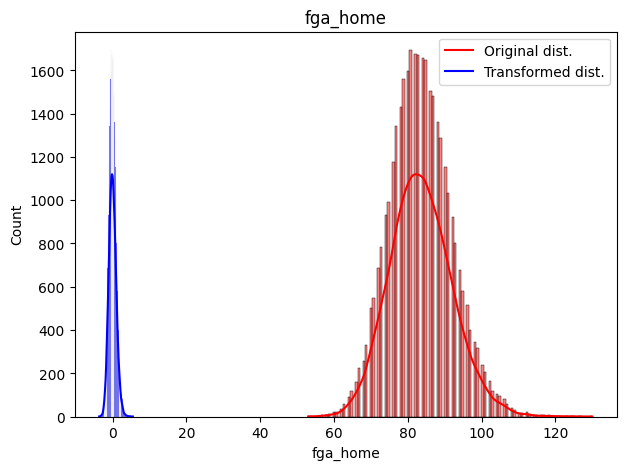

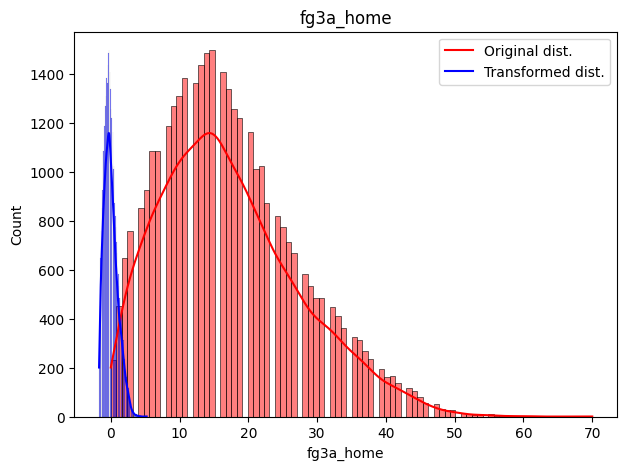

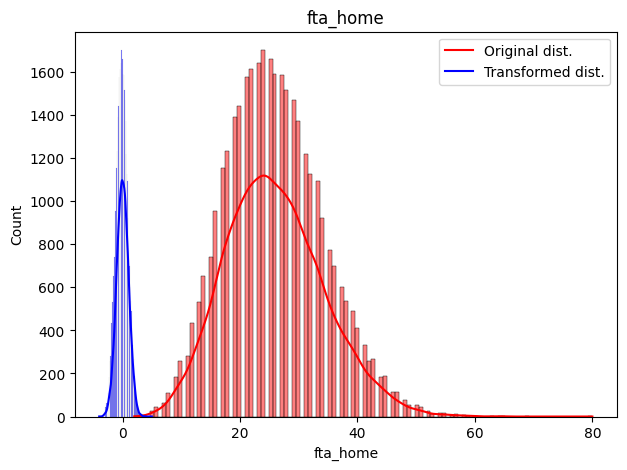

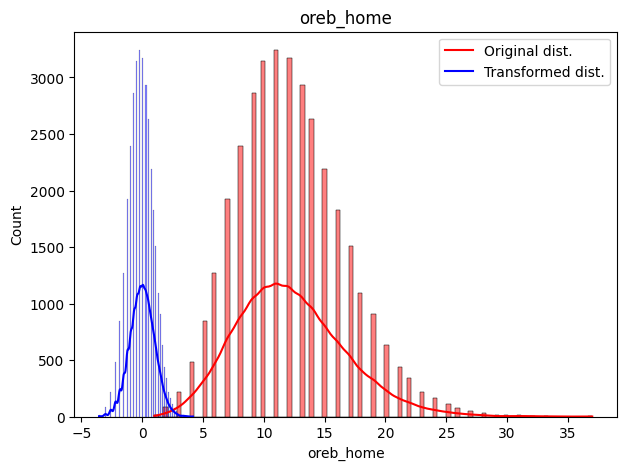

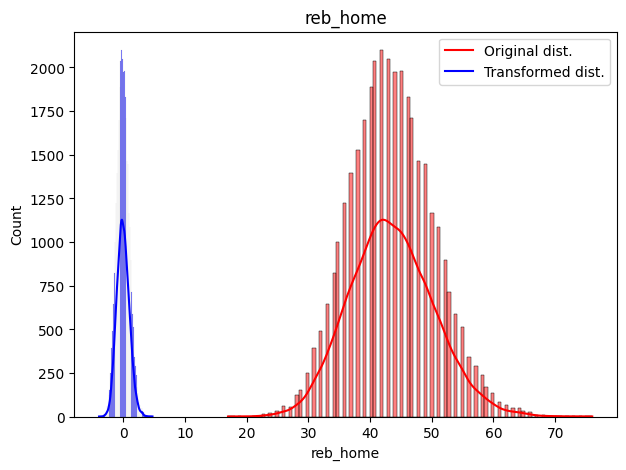

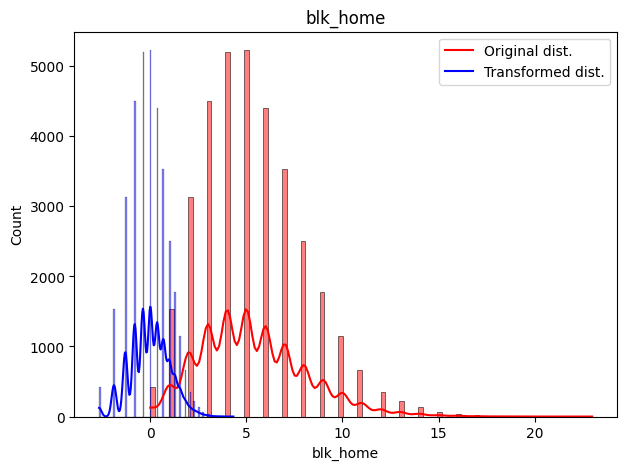

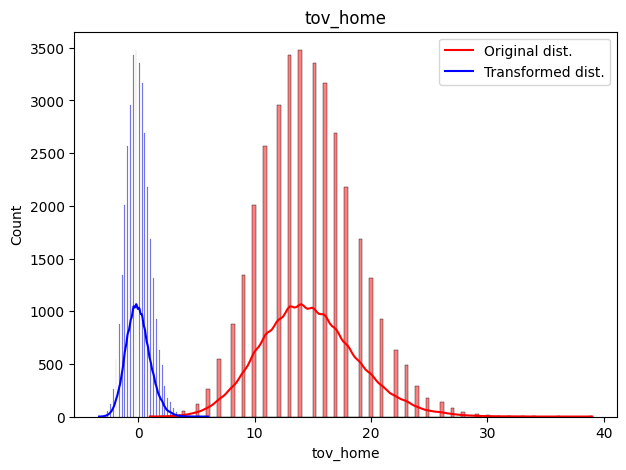

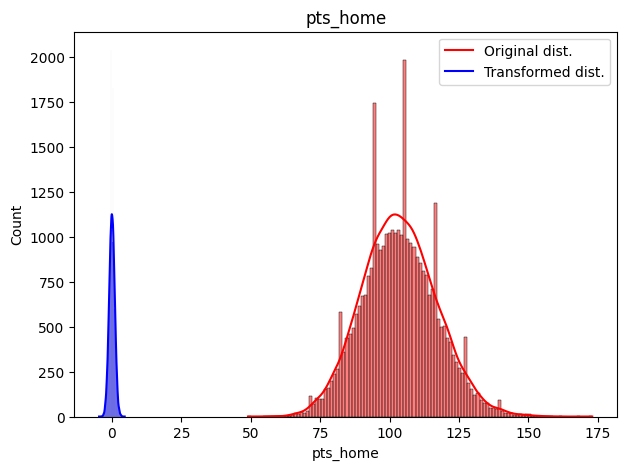

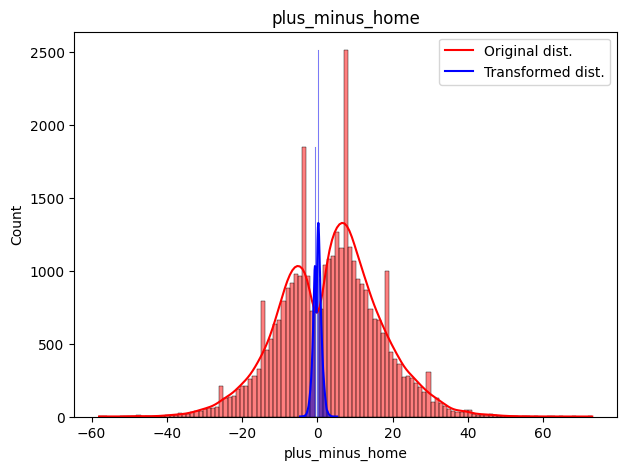

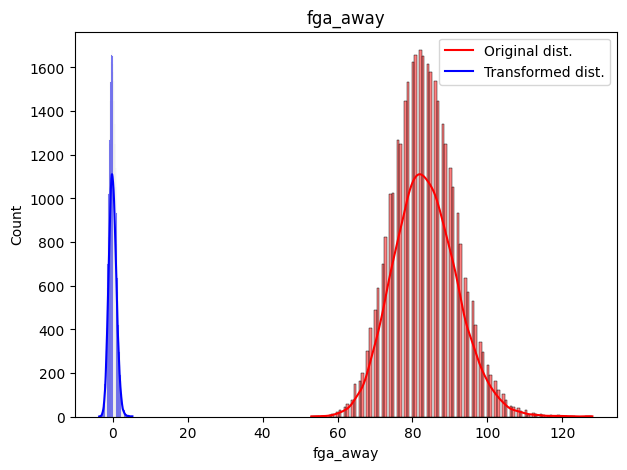

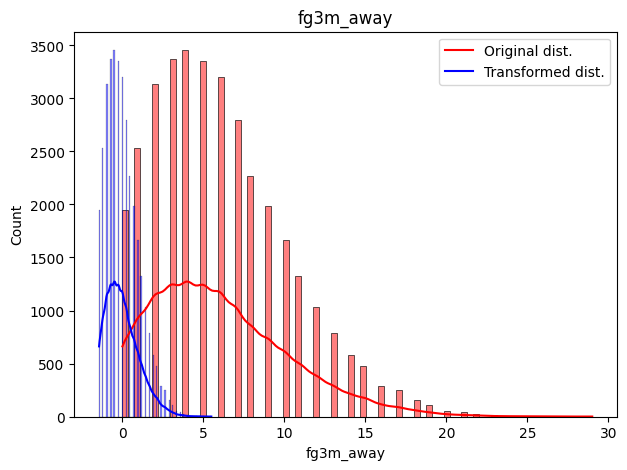

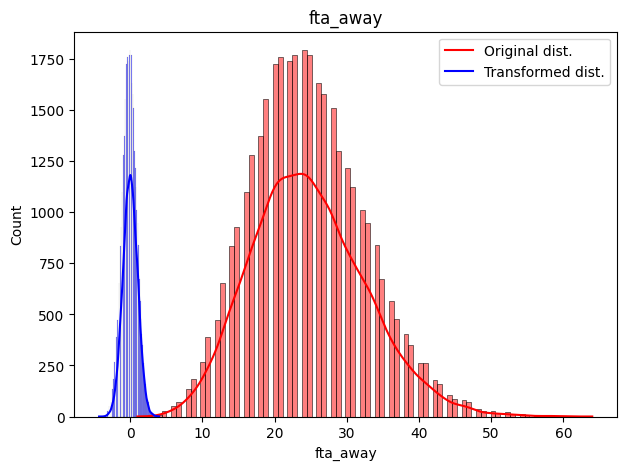

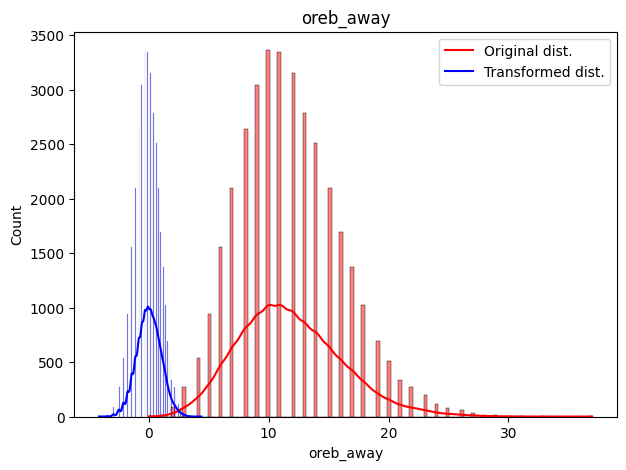

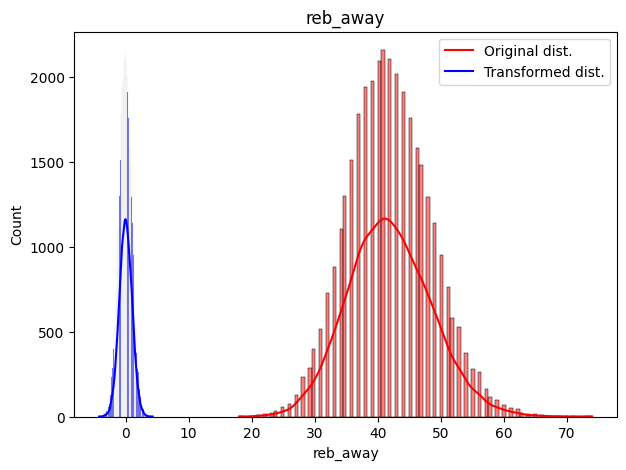

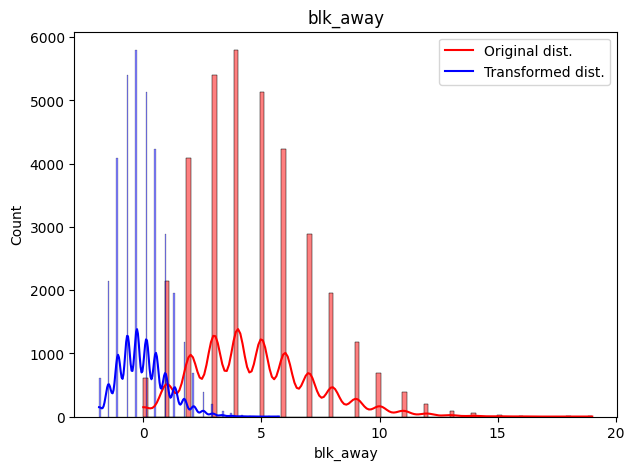

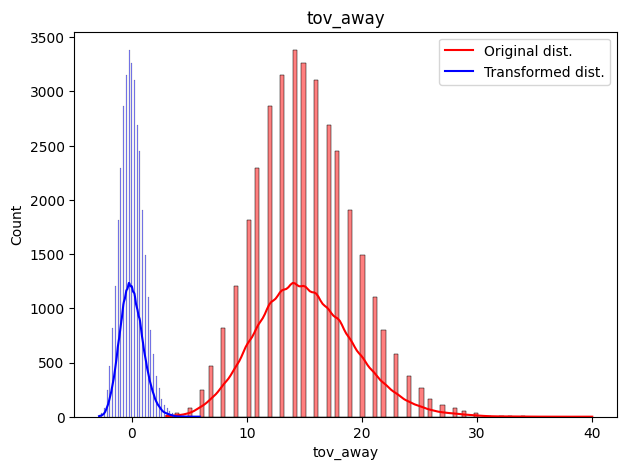

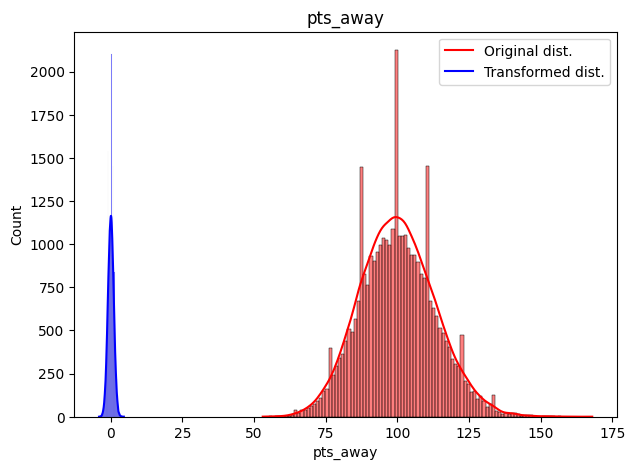

In [28]:
for col in cols:
    print("\n")
    fig, axes = plt.subplots(figsize=(7, 5))
    sns.histplot(data=X_TrainSet, x=col, kde=True, color="r")
    sns.histplot(data=X_transformed_scaled, x=col, kde=True, color="b")
    axes.set_title(f"{col}")
    axes.legend(labels=["Original dist.", "Transformed dist."])
    plt.show()
    print("\n")

The transformations may seem drastic. A lot of this is due to the scaling. When plotted on separate axes, `seaborn` adjusts the scale and the distributions look identical. Run the below cell to see.

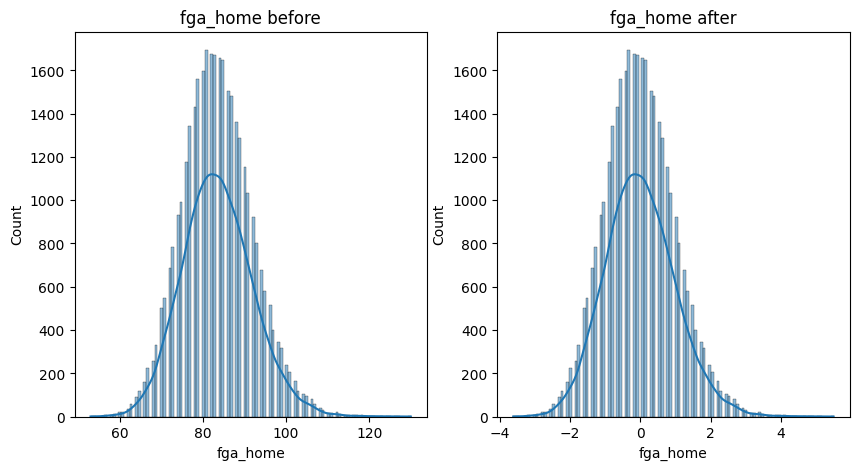

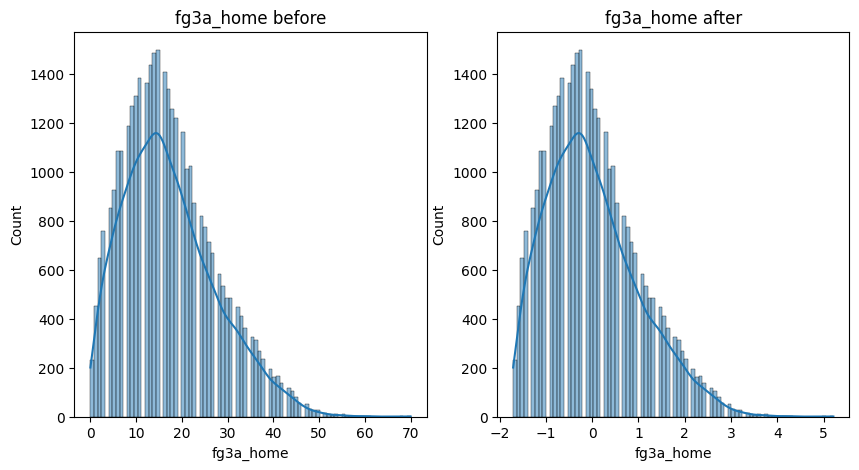

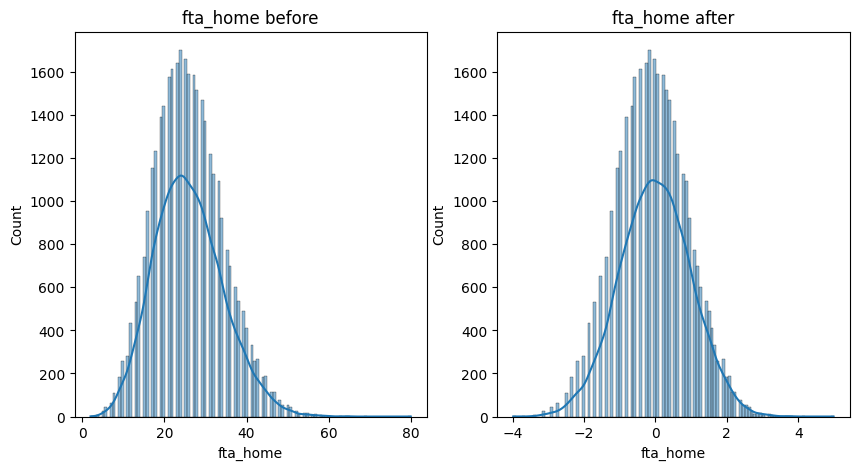

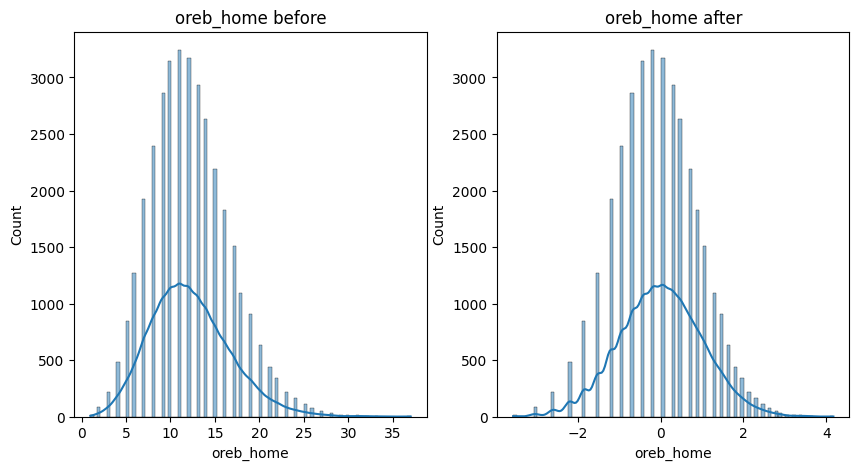

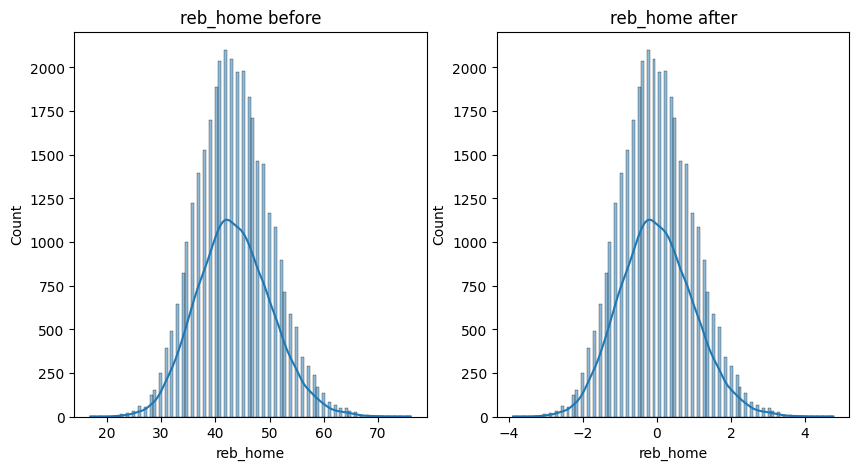

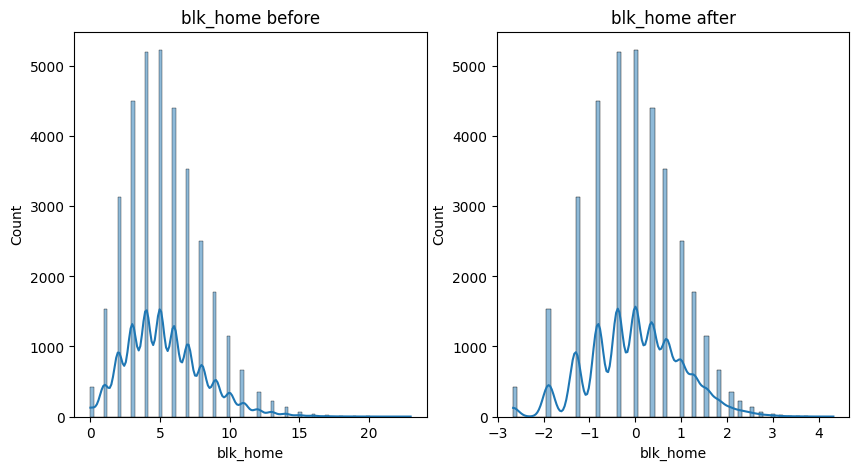

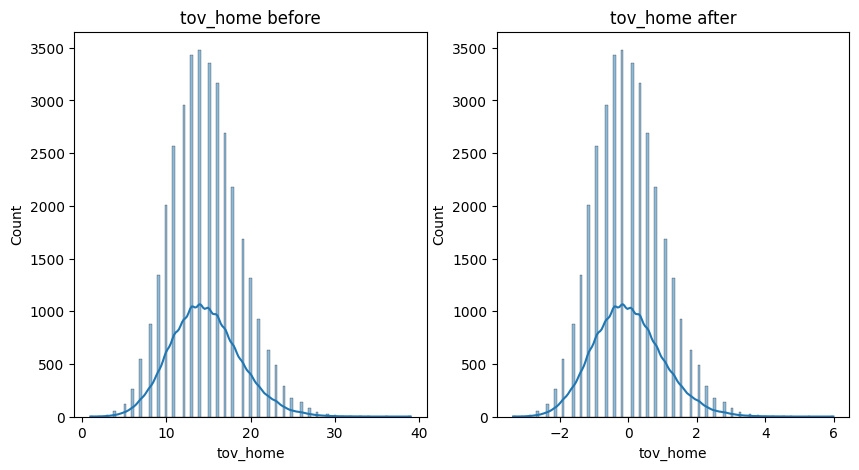

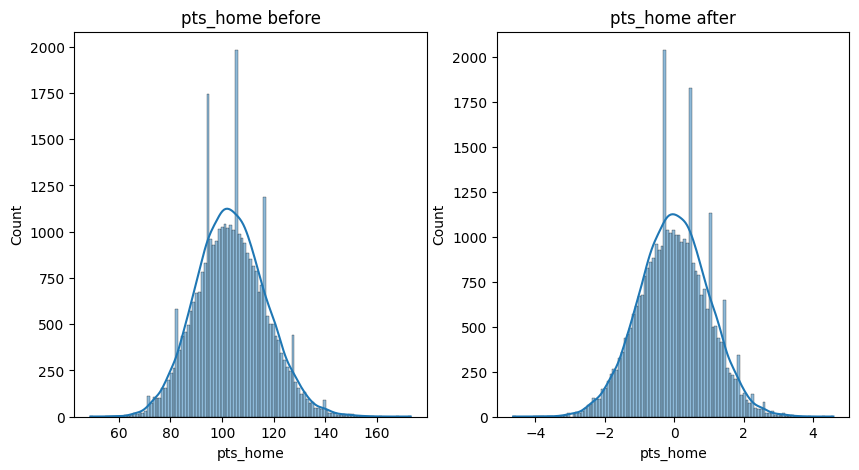

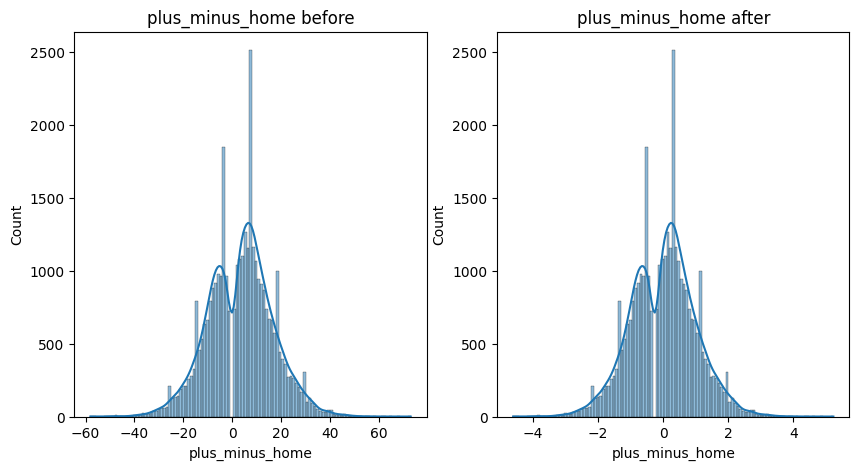

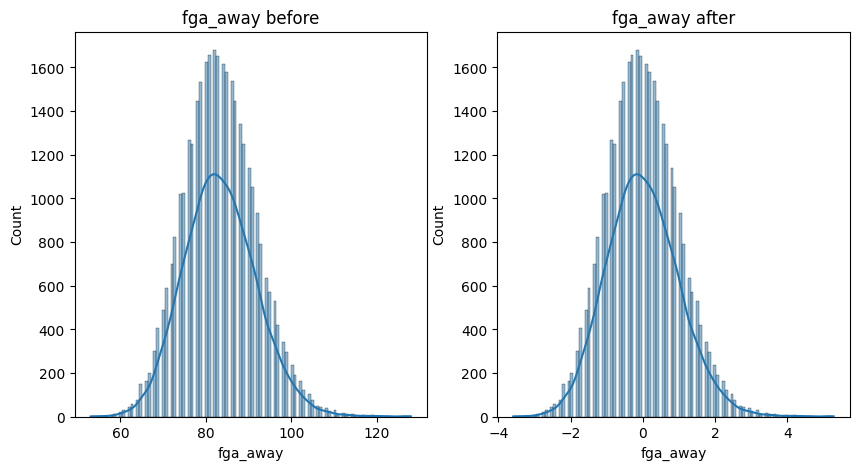

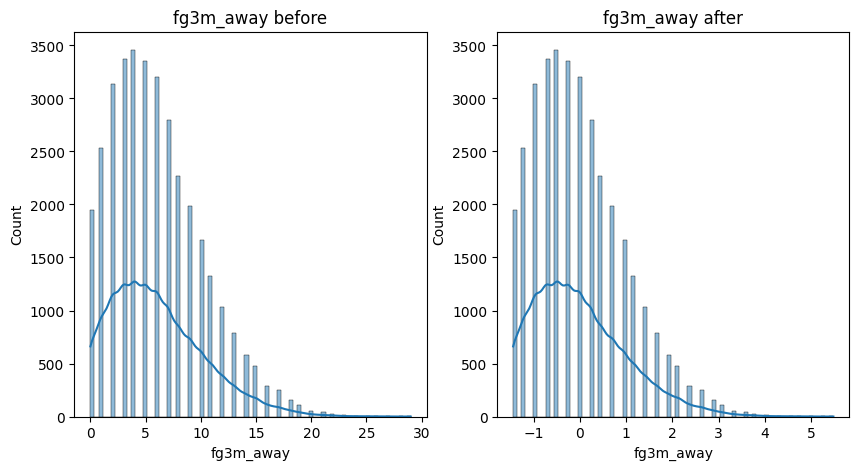

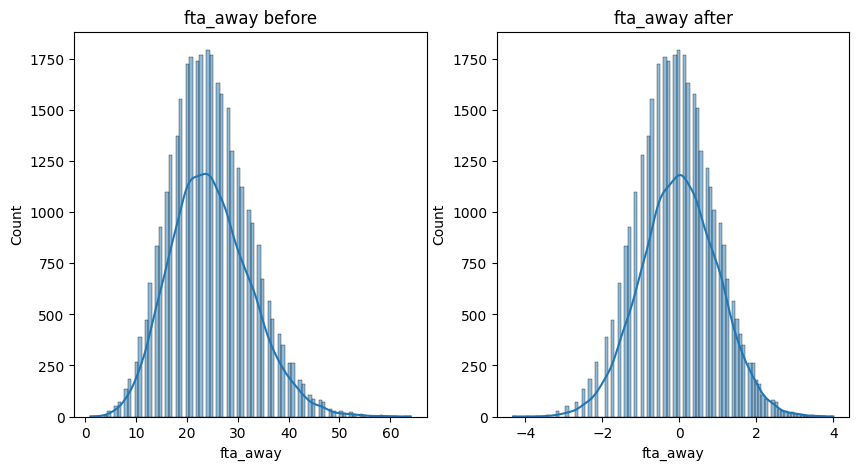

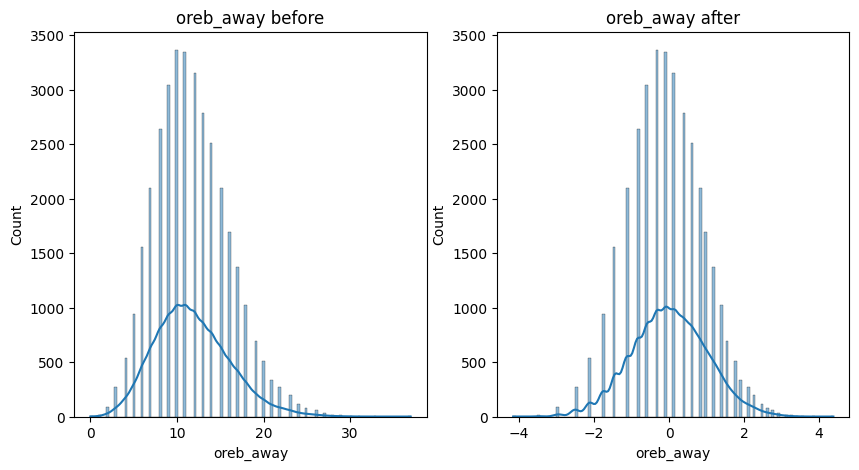

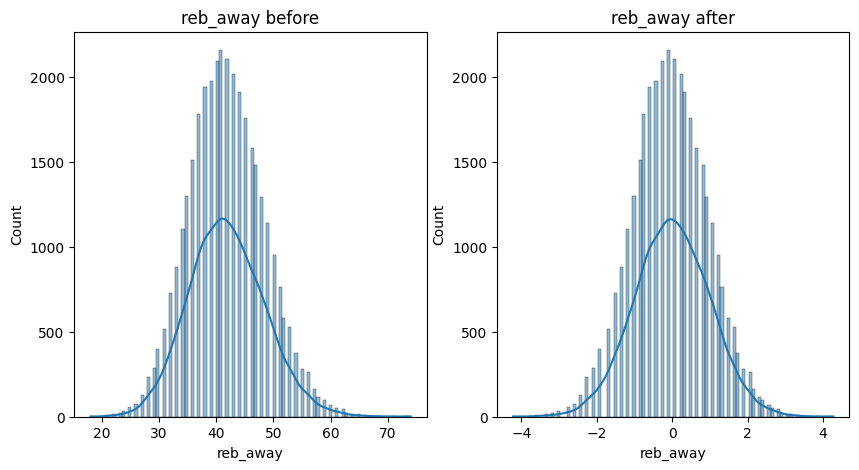

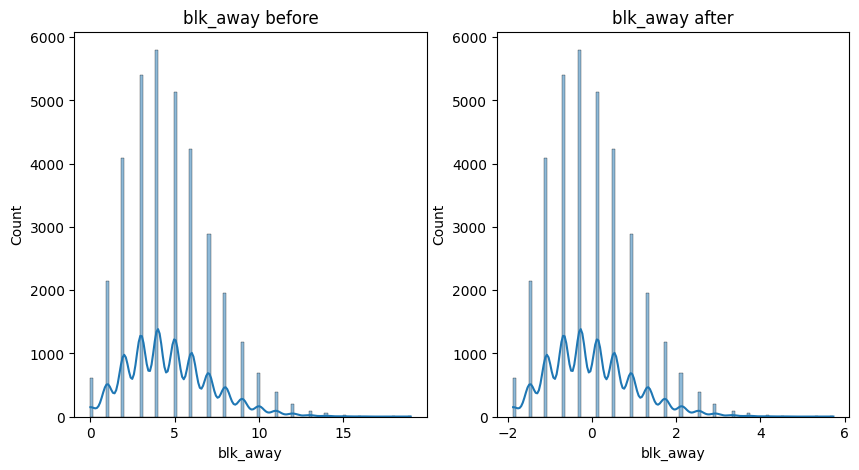

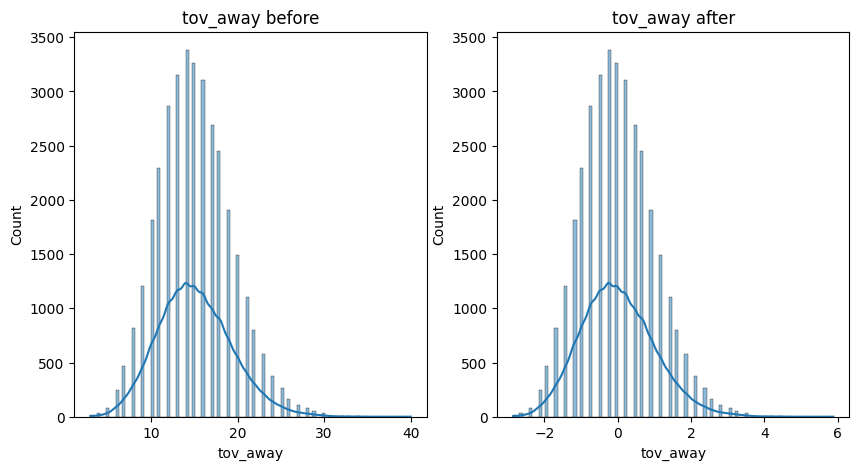

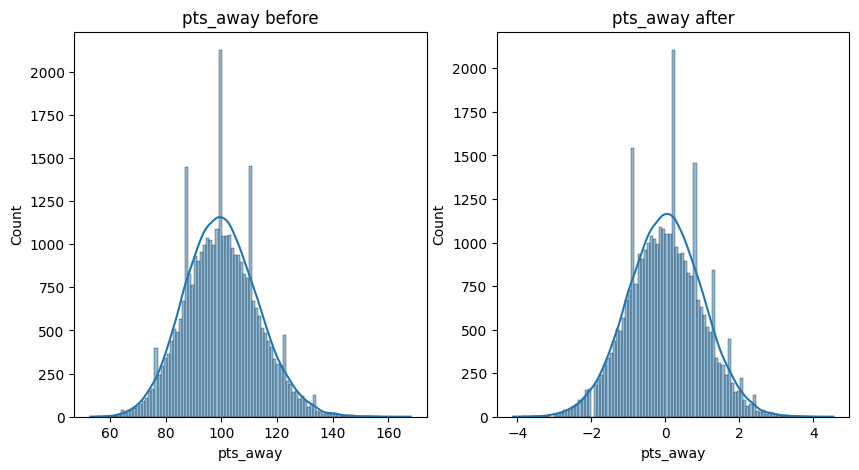

In [29]:
for col in cols:
    print("\n")
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
    sns.histplot(data=X_TrainSet, x=col, kde=True, ax=axes[0])
    sns.histplot(data=X_transformed_scaled, x=col, kde=True, ax=axes[1])
    axes[0].set_title(f"{col} before")
    axes[1].set_title(f"{col} after")
    plt.show()
    print("\n")

## Next steps
Now that we have done our feature engineering, we fill do a grid search in order to select the appropriate model. In the next notebook we will select some models to further tune as well as address Hypothesis 1.